# GAN with KL Divergence

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import keras.models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from google.colab import files

from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

Using TensorFlow backend.


## Weights and Placeholders

In [0]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [0]:
X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

## Load Data

In [0]:
mb_size = 128
Z_dim = 100
n_classes = 10

In [0]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as offi

## Pretrained Classifier
(for coverage metrics)

In [0]:
(x_sample, y_sample) = mnist.train.next_batch(60000)

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_sample, y_sample)

(x_val, y_val) = mnist.validation.next_batch(10000)

score = knn_model.score(x_val, y_val)
print("accuracy=%.2f%%" % (score * 100))

accuracy=97.44%


In [0]:
distr = tf.contrib.distributions

def prob_distr(img_batch):
  img_classes = knn_model.predict(img_batch)
  totals = np.sum(img_classes, axis=0)
  return totals/np.sum(totals)

def kl_divergence(img_batch):
  
  #prob distr of samples
  gen_pd = prob_distr(img_batch) 
  
  # number of modes covered in samples
  modes_covered = sum(1 for p in gen_pd if p > 0) 
  
  # kl divergence
  tiny_e = 1e-5
  gen_pd_epsilon = gen_pd + tiny_e
  data_pd = np.full((n_classes,),(1/n_classes)) + tiny_e
  kl = np.sum(gen_pd_epsilon * np.log(gen_pd_epsilon / data_pd)) 
  rev_kl = np.sum(data_pd * np.log(data_pd / gen_pd_epsilon)) 
  
  return kl, rev_kl, gen_pd, modes_covered

## Model 

### Architectures

In [0]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.1, hspace=0.1)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

### Loss functions

In [0]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

#KL = distr.kl_divergence(distr.Categorical(probs=prob_distr(G_sample)), distr.Categorical(probs= np.full((n_classes,),(1/n_classes))), allow_nan_stats=True)

## Training Session

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
if not os.path.exists('out/'):
    os.makedirs('out/')

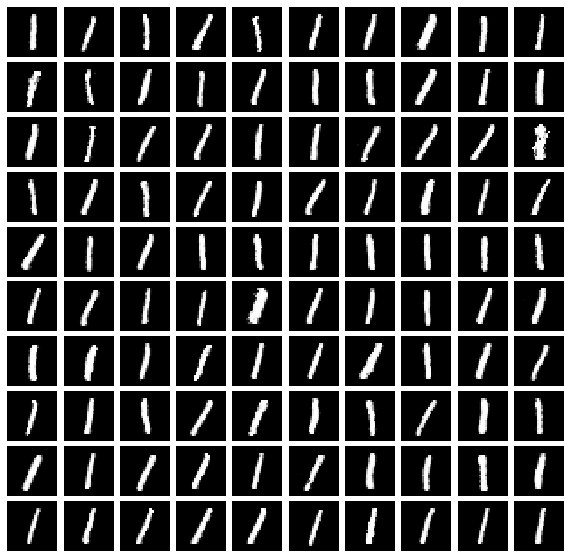

Iter: 0
D loss: 0.178
G_loss: 3.373
KL Div: 2.302
Reverse KL Div: 8.06



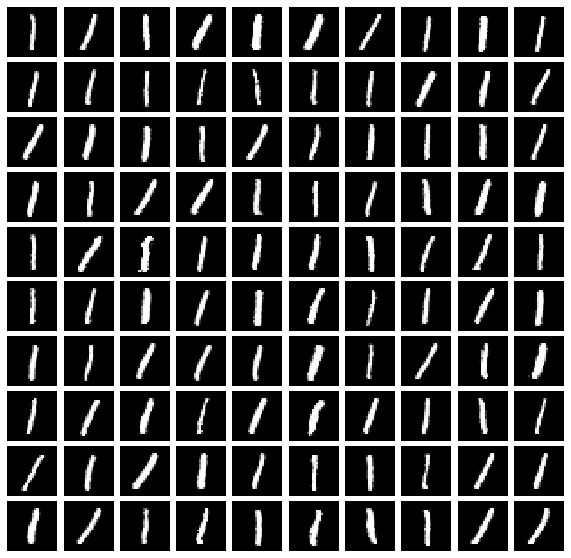

Iter: 1000
D loss: 0.3039
G_loss: 2.939
KL Div: 2.302
Reverse KL Div: 8.06



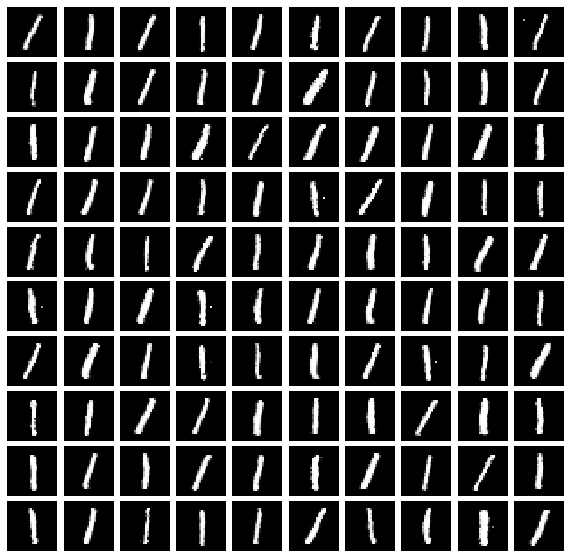

Iter: 2000
D loss: 0.2672
G_loss: 3.157
KL Div: 2.302
Reverse KL Div: 8.06



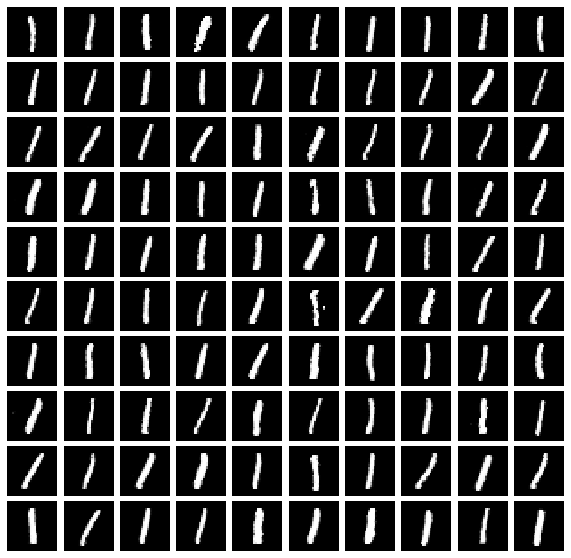

Iter: 3000
D loss: 0.2582
G_loss: 3.157
KL Div: 2.302
Reverse KL Div: 8.06



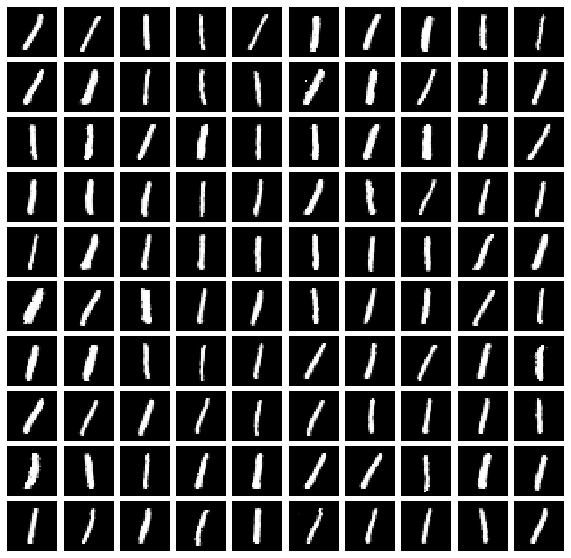

Iter: 4000
D loss: 0.1839
G_loss: 3.135
KL Div: 2.302
Reverse KL Div: 8.06



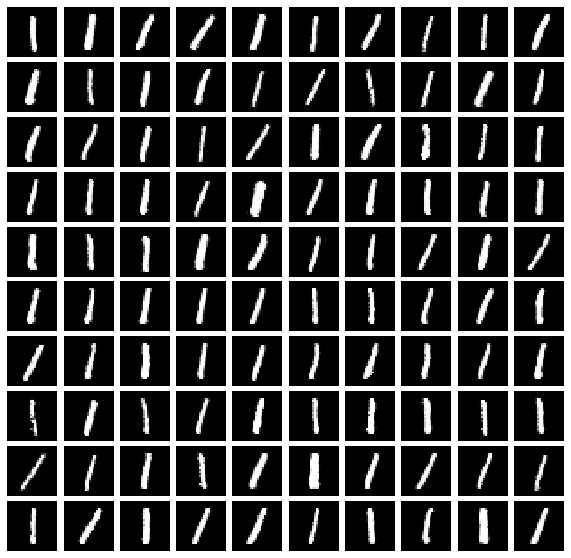

Iter: 5000
D loss: 0.2366
G_loss: 3.159
KL Div: 2.302
Reverse KL Div: 8.06



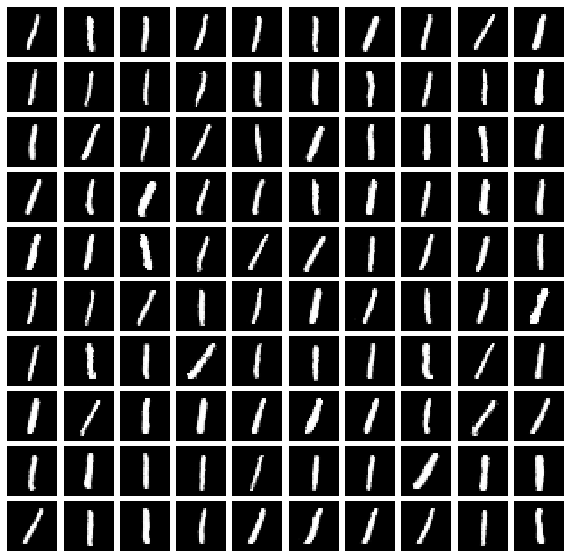

Iter: 6000
D loss: 0.186
G_loss: 3.391
KL Div: 2.302
Reverse KL Div: 8.06



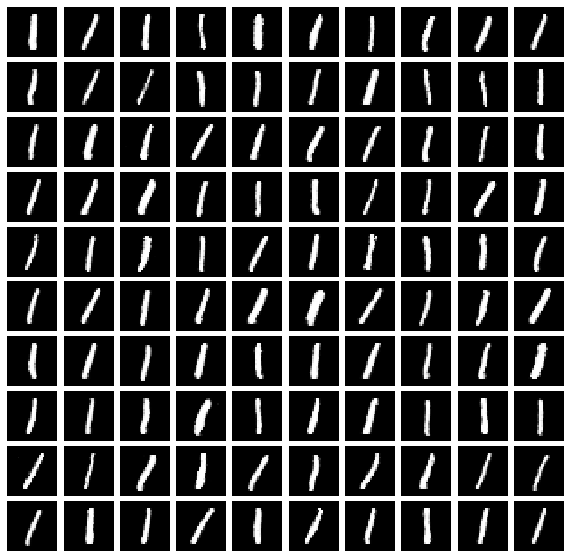

Iter: 7000
D loss: 0.2671
G_loss: 3.51
KL Div: 2.302
Reverse KL Div: 8.06



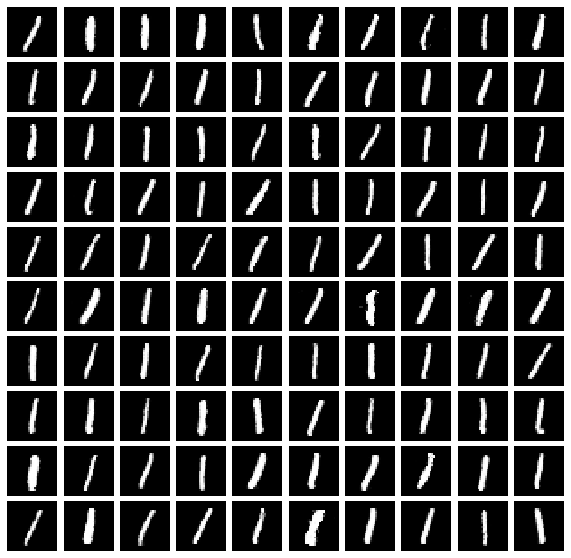

Iter: 8000
D loss: 0.3221
G_loss: 3.058
KL Div: 2.302
Reverse KL Div: 8.06



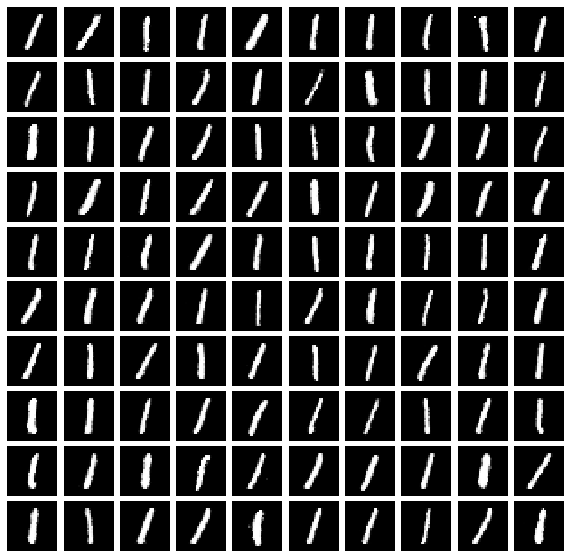

Iter: 9000
D loss: 0.2056
G_loss: 3.213
KL Div: 2.302
Reverse KL Div: 8.06



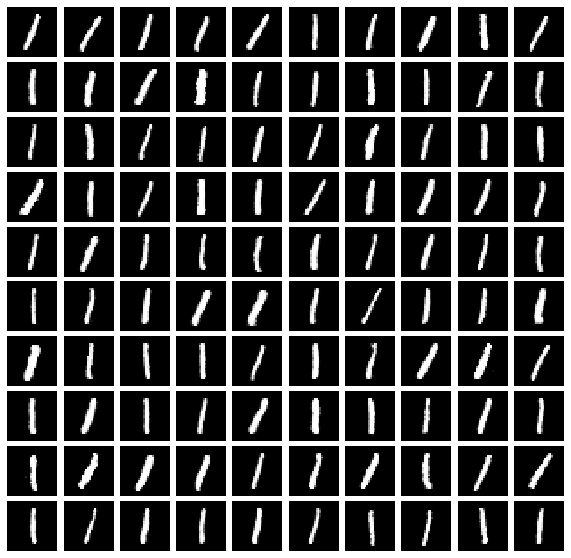

Iter: 10000
D loss: 0.3332
G_loss: 3.252
KL Div: 2.302
Reverse KL Div: 8.06



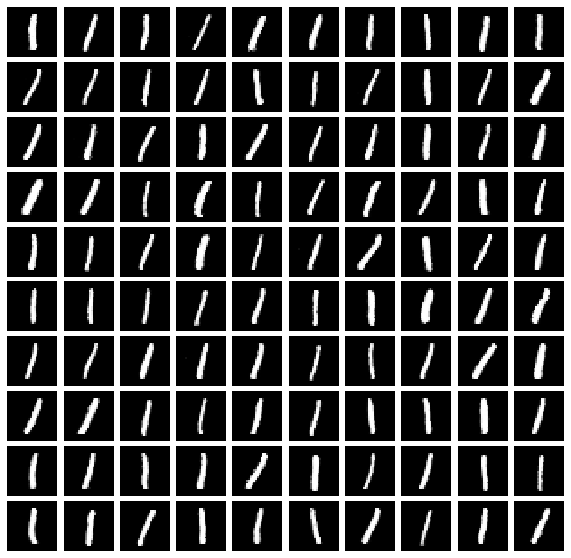

Iter: 11000
D loss: 0.2606
G_loss: 2.978
KL Div: 2.302
Reverse KL Div: 8.06



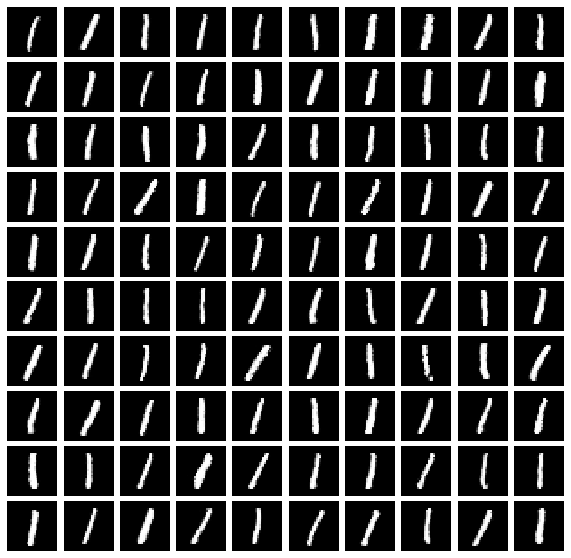

Iter: 12000
D loss: 0.2074
G_loss: 3.333
KL Div: 2.302
Reverse KL Div: 8.06



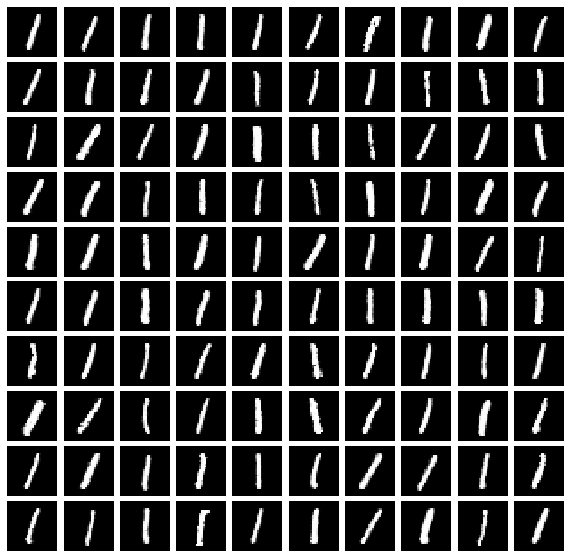

Iter: 13000
D loss: 0.2797
G_loss: 3.119
KL Div: 2.302
Reverse KL Div: 8.06



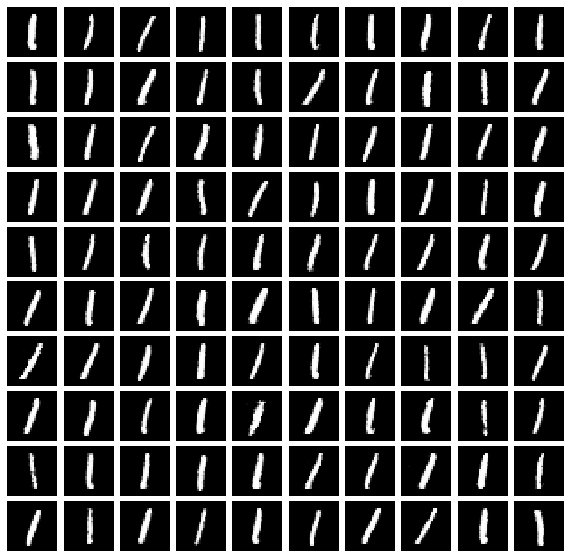

Iter: 14000
D loss: 0.3859
G_loss: 3.122
KL Div: 2.302
Reverse KL Div: 8.06



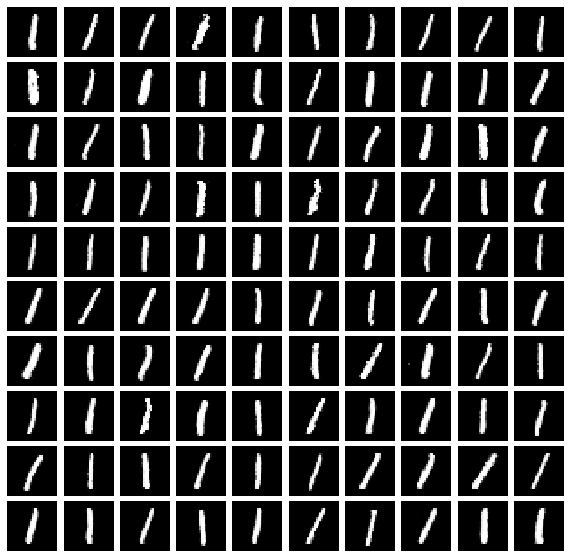

Iter: 15000
D loss: 0.2578
G_loss: 3.468
KL Div: 2.302
Reverse KL Div: 8.06



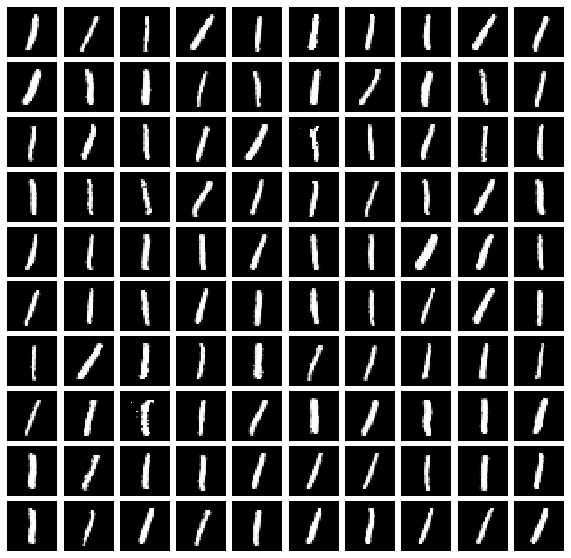

Iter: 16000
D loss: 0.3028
G_loss: 3.178
KL Div: 2.302
Reverse KL Div: 8.06



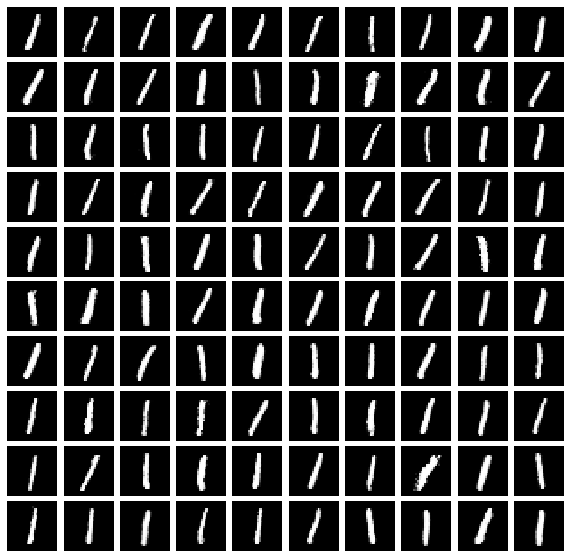

Iter: 17000
D loss: 0.2137
G_loss: 2.903
KL Div: 2.302
Reverse KL Div: 8.06



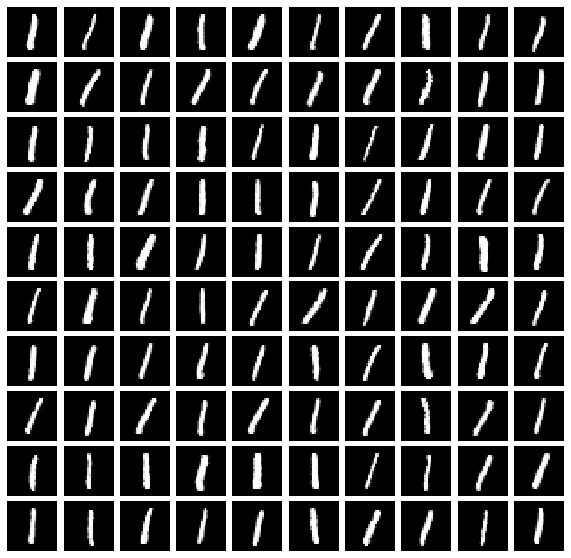

Iter: 18000
D loss: 0.2336
G_loss: 3.076
KL Div: 2.302
Reverse KL Div: 8.06



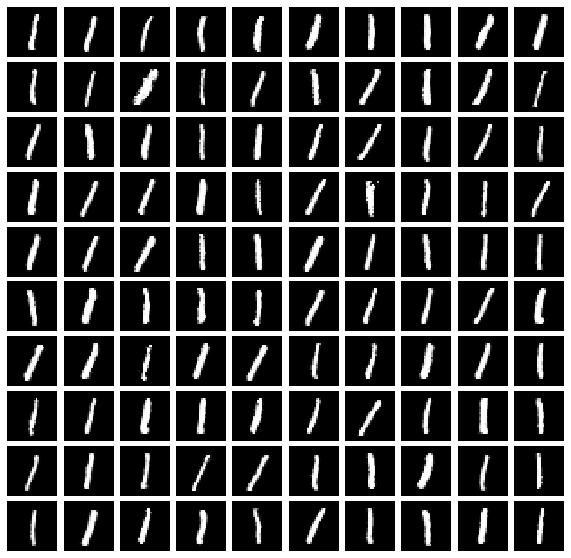

Iter: 19000
D loss: 0.1905
G_loss: 3.185
KL Div: 2.302
Reverse KL Div: 8.06



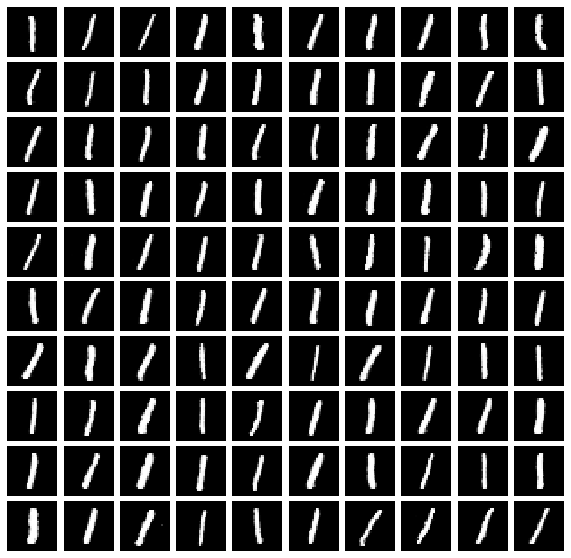

Iter: 20000
D loss: 0.1873
G_loss: 2.989
KL Div: 2.302
Reverse KL Div: 8.06



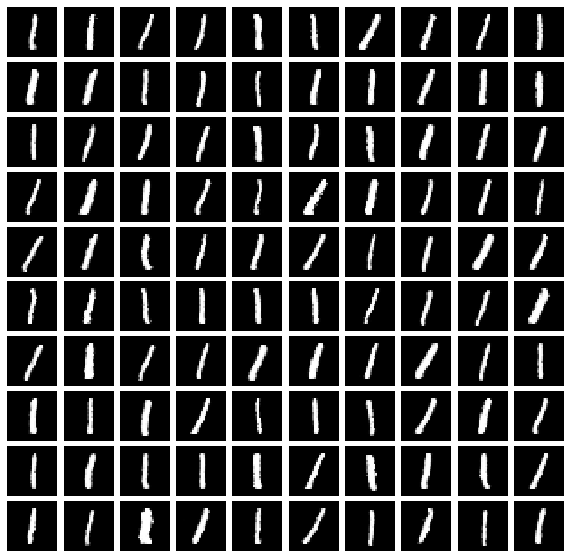

Iter: 21000
D loss: 0.2444
G_loss: 3.679
KL Div: 2.302
Reverse KL Div: 8.06



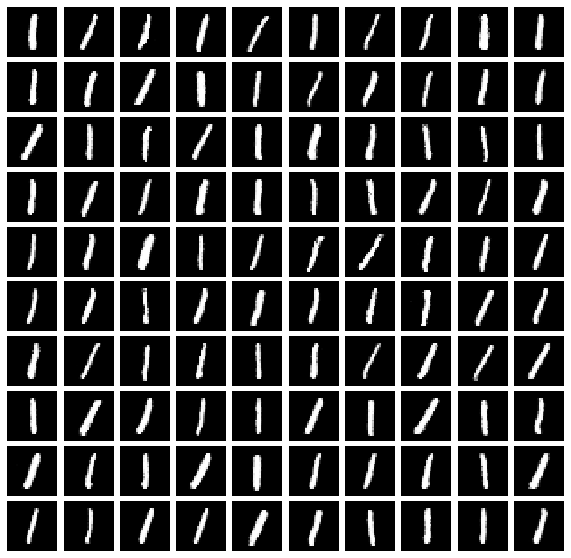

Iter: 22000
D loss: 0.245
G_loss: 3.22
KL Div: 2.302
Reverse KL Div: 8.06



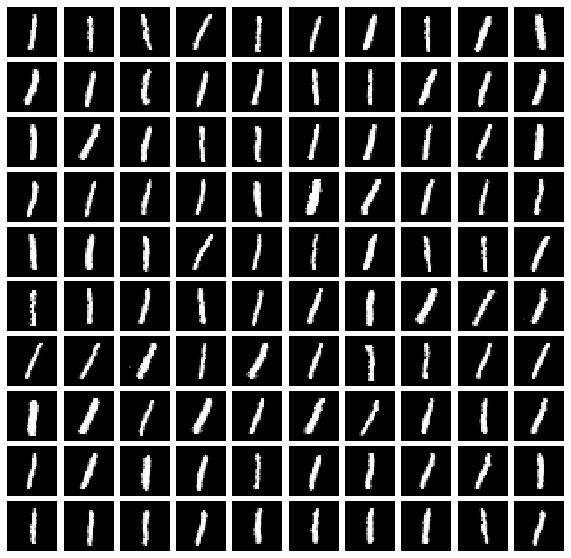

Iter: 23000
D loss: 0.2864
G_loss: 3.267
KL Div: 2.302
Reverse KL Div: 8.06



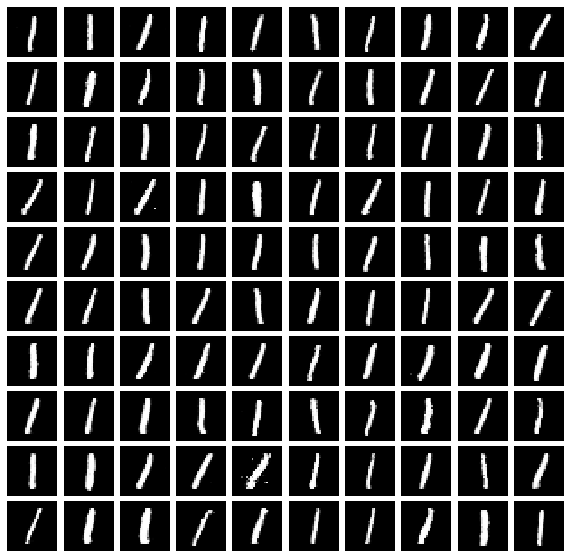

Iter: 24000
D loss: 0.1897
G_loss: 3.105
KL Div: 2.302
Reverse KL Div: 8.06



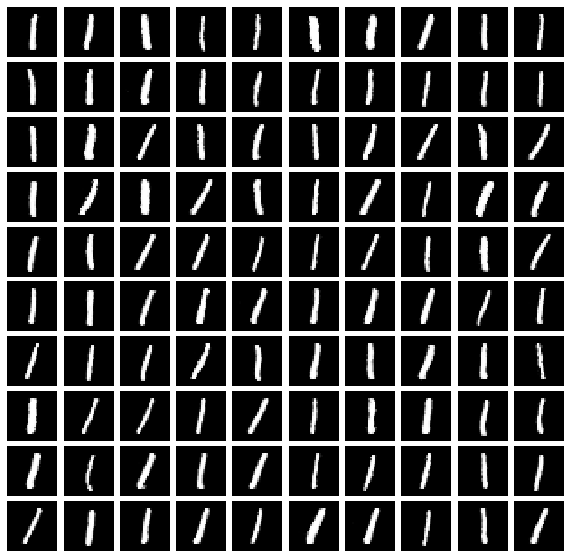

Iter: 25000
D loss: 0.2195
G_loss: 3.028
KL Div: 2.302
Reverse KL Div: 8.06



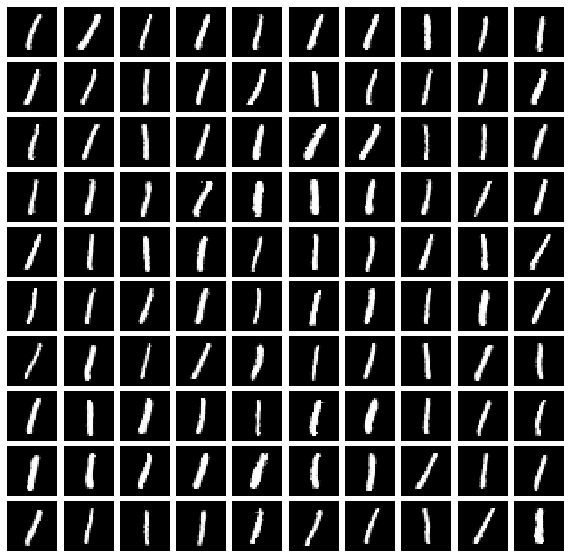

Iter: 26000
D loss: 0.2117
G_loss: 3.11
KL Div: 2.302
Reverse KL Div: 8.06



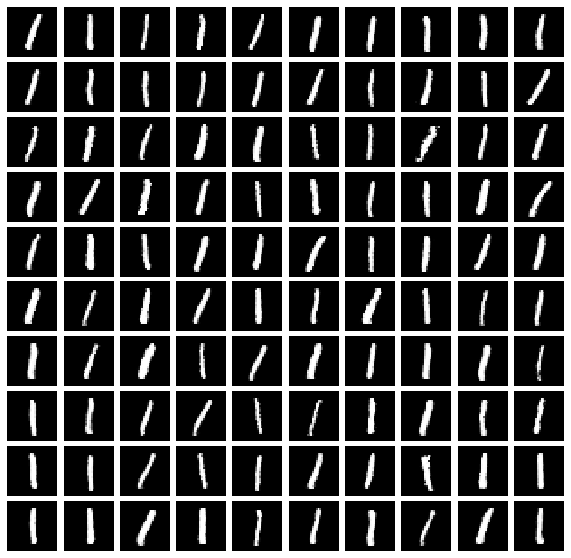

In [0]:
i = 0
g_losses, d_losses, kls, rev_kls, pds, mcs = [], [], [], [], [], []
for it in range(1000000):
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(100, Z_dim)})
        
        fig = plot(samples)
        plt.show(fig)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 1000 == 0:
        kl_samples = sess.run(G_sample, feed_dict={Z: sample_Z(200, Z_dim)})
        kl, rev_kl, pd, mc = kl_divergence(kl_samples)
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('KL Div: {:.4}'.format(kl))
        print('Reverse KL Div: {:.4}'.format(rev_kl))
        g_losses.append(D_loss_curr)
        d_losses.append(G_loss_curr)
        kls.append(kl)
        rev_kls.append(rev_kl)
        pds.append(pd)
        mcs.append(mc)
        print()

## Metric Evaluation

In [0]:
# Jensen-Shanon Divergence
tiny_e = 1e-5

m = (pds + np.full_like(pds,0.1))/2
m_epsilon = m + tiny_e
gen_pd_epsilon = np.array(pds) + tiny_e
data_pd_epsilon = np.full_like(pds,0.1) + tiny_e

kl_g_m = np.sum(gen_pd_epsilon * np.log(gen_pd_epsilon / m_epsilon), axis=1)
kl_d_m = np.sum(data_pd_epsilon * np.log(data_pd_epsilon / m_epsilon), axis=1)

jsd = (kl_g_m/2) + (kl_d_m/2)
print(jsd.shape)

(295,)


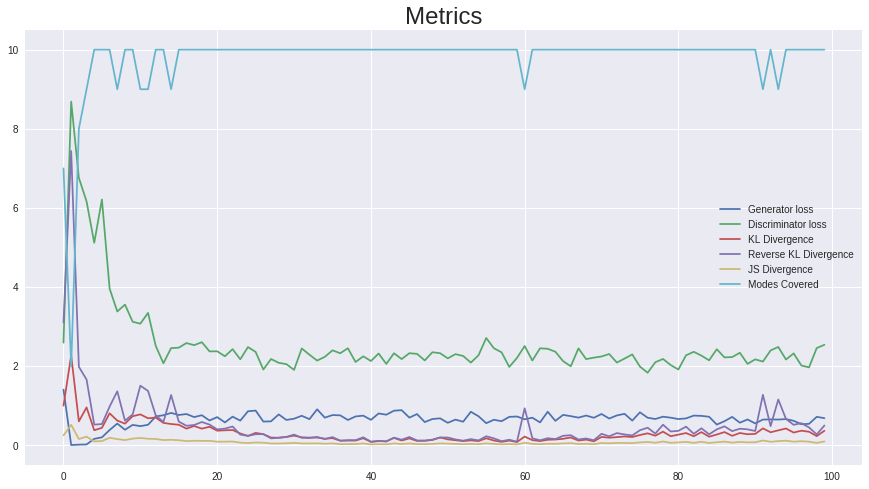

In [0]:
fig = plt.figure(figsize=(15,8))

for (metric, label) in zip([g_losses, d_losses, kls, rev_kls, jsd, mcs], ['Generator loss', 'Discriminator loss', 'KL Divergence', 'Reverse KL Divergence', 'JS Divergence', 'Modes Covered']):
  
  plt.plot(metric, label=label)
  plt.title('Metrics', fontsize=24)
  plt.legend()

plt.savefig("metrics.png")
plt.show()

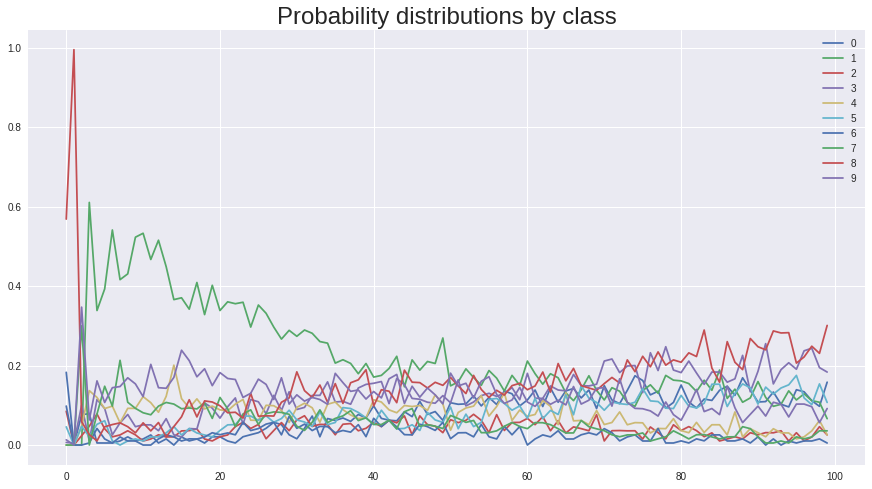

In [0]:
# plot probability distributions

fig = plt.figure(figsize=(15,8))

for (digit, label) in zip(np.array(pds).T, range(10)):
  
  plt.plot(digit, label=label)
  plt.title('Probability distributions by class', fontsize=24)
  plt.legend()

plt.savefig("prob_distr.png")
plt.show()


## Download

In [0]:
from google.colab import files

metrics_list = [(g_losses, "g_losses"),
(d_losses, "d_losses"),
(kls, "kl_divergences"),
(rev_kls, "rev_kl_divergences"),
(pds, "prob_distributions"),
(jsd, "js_divergences"),
(mcs, "modes_covered")]

for (metric, label) in metrics_list:
  with open(label+'.txt', 'w') as f:
    f.write(str(metric))
  files.download(label+'.txt')

In [0]:
files.download("prob_distr.png")
files.download("metrics.png")